
**IIIT Hyderabad**

**Computer Vision(CS7.505)**

**Instructor: Anoop Namboodiri**

                                                            


**Assignment 3**

**Name: Yash Motwani**

**Roll number: 2020122002**

---







# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Avinash, Samartha  
**Release date**: 21/03/22  
**Submission date** : 02/04/22

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
![graphcut.png](attachment:graphcut.png)

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [ ]:
! pip install sklearn
! pip install python-igraph

In [ ]:
import sys
import cv2
import numpy as np
from igraph import Graph
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix  

In [ ]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, _mainMask, _maskFg, _maskBg, img, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mainMask = _mainMask
        self._maskFg = _maskFg
        self._maskBg = _maskBg
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img

    @property
    def mainMask(self):
        return self._mainMask
    
    @mainMask.setter
    def mainMask(self, _mask):
        self._mainMask = _mask

    @property
    def maskFg(self):
        return self._maskFg
    
    @maskFg.setter
    def maskFg(self, _mask):
        self._maskFg = _mask

    @property
    def maskBg(self):
        return self._maskBg
    
    @maskBg.setter
    def maskBg(self, _mask):
        self._maskBg = _mask

    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                if self.FLAGS['value']['val'] == 1:
                    cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskFg, (x,y), 3, self.FLAGS['value']['val'], -1)
                else:
                    cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskBg, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mainMask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                if self.FLAGS['value']['val'] == 1:
                    cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskFg, (x, y), 3, self.FLAGS['value']['val'], -1)
                else:
                    cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskBg, (x, y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mainMask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                if self.FLAGS['value']['val'] == 1:
                    cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskFg, (x, y), 3, self.FLAGS['value']['val'], -1)
                else:
                    cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                    cv2.circle(self._maskBg, (x, y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mainMask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [ ]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()
    mainMask = np.ones(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    maskFg = np.zeros(img.shape[:2], dtype = np.uint8)
    maskBg = np.ones(img.shape[:2], dtype = np.uint8)
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image', cv2.WINDOW_GUI_NORMAL)
    cv2.namedWindow('Segmented image')
    
    EventObj = EventHandler(FLAGS, mainMask, maskFg, maskBg, img, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)

    boxfl = True
    while(1):
        
        img = EventObj.image
        mainMask = EventObj.mainMask
        maskFg = EventObj.maskFg
        maskBg = EventObj.maskBg
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(100)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, img.shape[0]-1, img.shape[1]-1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mainMask = np.ones(img.shape[:2], np.uint8) 
            maskFg = np.zeros(img.shape[:2], np.uint8) 
            maskBg = np.ones(img.shape[:2], np.uint8) 
            EventObj.image = img
            EventObj.mainMask = mainMask
            EventObj.maskFg = maskFg
            EventObj.maskBg = maskBg
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            if boxfl:
                EventObj.mainMask, graph, edges, weights = grabCut(cv2.cvtColor(img2, \
                                                        cv2.COLOR_BGR2RGB), \
                                                        list(FLAGS['RECT']), \
                                                        mainMask, 50, its=5, k=5)
                boxfl = False
            else:
                EventObj.mainMask = refineCut(maskFg, maskBg, graph, edges, weights, 50)

        EventObj.flags = FLAGS
        mask2 = np.where((mainMask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)
        mask2=mask2/255
        mask2.flatten()
        mask2=np.round(mask2)
        ground=cv2.imread('/home/yash/cv/ground_truth/flower.bmp',0)
        accuracy=(mask2 == ground).sum()/np.prod(mask2.shape)
        print(" The Accuracy is " , accuracy)
        jacc,dice=jacc_dice(ground,mask2)
        print(" The Jaccard similarity is " , jacc)
        print(" The Dice similarity coefficient: is " , dice)

In [ ]:
def new_nodes(graph, rows, cols):
    dim=rows * cols
    minCut = graph.mincut(dim, dim + 1, capacity='weight')
    xx = np.array(minCut[1])
    yy = np.array(minCut[0])
    output=xx[xx < dim], yy[yy < dim]
    return output

def weights_edge(edges, weights, fg_nodes, image, GMM_bg, GMM_fg):
    rows, cols, _ = image.shape

    temp_N = np.full(fg_nodes.shape[0], rows * cols).reshape(-1, 1)
    temp_N = np.concatenate((fg_nodes, temp_N), axis=1)
    temp_W = -GMM_bg.score_samples(image.reshape([rows * cols, 3])[fg_nodes].reshape(-1, 3)).reshape(-1, 1)
    current_edge = np.concatenate((edges, temp_N), axis=0)
    current_weight = np.concatenate((weights, temp_W), axis=0)


    temp_N = np.full(fg_nodes.shape[0], rows * cols + 1).reshape(-1, 1)
    temp_N = np.concatenate((fg_nodes, temp_N), axis=1)
    temp_W = -GMM_fg.score_samples(image.reshape([rows*cols, 3])[fg_nodes].reshape(-1, 3)).reshape(-1, 1)
    current_edge = np.concatenate((current_edge, temp_N), axis=0).astype(np.int)
    current_weight = np.concatenate((current_weight, temp_W), axis=0)

    return current_edge, current_weight



def create_graph(mask, nodes, pixels, gamma):
    edges = []
    i_iter=nodes.shape[0]-1
    j_iter=nodes.shape[1]-1
    weights = []
    # Vertical edges
    for i in range(i_iter):
        for j in range(j_iter+1):
            edges.append([nodes[i][j], nodes[i+1][j]])
            diff=pixels[i][j] - pixels[i+1][j]
            weight=np.sum(diff)**2
            weights.append(weight)

    # top-left to bottom-right edges
    for i in range(i_iter):
        for j in range(j_iter):
            edges.append([nodes[i][j], nodes[i+1][j+1]])
            diff=pixels[i][j] - pixels[i+1][j+1]
            weight=(np.sum(diff)**2) / np.sqrt(2)
            weights.append(weight)

    # top-right to bottom-left edges
    for i in range(i_iter):
        for j in range(1, nodes.shape[1]):
            edges.append([nodes[i][j], nodes[i+1][j-1]])
            diff=pixels[i][j] - pixels[i+1][j-1]
            weight=(np.sum(diff)**2) / np.sqrt(2)
            weights.append(weight)
    # Horizontal edges
    for i in range(i_iter+1):
        for j in range(j_iter):
            edges.append([nodes[i][j], nodes[i][j+1]])
            diff=pixels[i][j] - pixels[i][j+1]
            weight=np.sum(diff)**2
            weights.append(weight)

    edges = np.array(edges)
    weights = np.array(weights)

    rows, cols, _ = pixels.shape
    ba=cols*(rows - 1)
    bb= (cols - 1)*rows 
    bc= 2*(cols - 1)*(rows - 1)
    b = ba+bb+bc
    b = 1/(2*np.sum(weights)/b)
    weights=gamma * np.exp(-b * weights)
    weights = (weights).reshape(-1, 1)


    bg_nodes = nodes[mask==0].reshape(-1, 1)
    fg_nodes = nodes[mask==1].reshape(-1, 1)
    

    edges = np.concatenate((edges, np.concatenate((bg_nodes,np.full(bg_nodes.shape[0], rows * cols).reshape(-1, 1)), axis=1)), axis=0)
    weight_con=np.zeros((bg_nodes.shape[0], 1))
    weights = np.concatenate((weights, weight_con), axis=0)


    edges = np.concatenate((edges, np.concatenate((bg_nodes,np.full(bg_nodes.shape[0], rows * cols + 1).reshape(-1, 1)), axis=1)), axis=0)
    gamma*=9
    weight_con= gamma * np.ones((bg_nodes.shape[0], 1))
    weights = np.concatenate((weights, weight_con), axis=0)
        
    return edges, weights, bg_nodes, fg_nodes

def refineCut(maskFg, maskBg, graph, edges, weights, gamma):
    sys.stdout.write("\rRefining...")
    sys.stdout.flush()
    cols, rows = maskFg.shape
    dim=cols * rows
    nodes = np.arange(dim).reshape(cols, rows)
    # Find nodes
    FG = nodes[maskFg==1].reshape(-1, 1)
    BG = nodes[maskBg==0].reshape(-1, 1)
    FG= np.full(len(FG),dim)
    BG=np.full(len(BG),dim)
    FG1 = np.hstack((FG,  FG.reshape(-1, 1)))
    FG2 = np.hstack((FG, np.full(len(FG),dim + 1).reshape(-1, 1)))
    BG1 = np.hstack((BG, BG.reshape(-1, 1)))
    BG2 = np.hstack((BG, np.full(len(BG),dim + 1).reshape(-1, 1)))
    weight_vocab = {}
    # Store weights 
    gamma =gamma* 9
    for k in BG1:
        weight_vocab[tuple(k)] = 0
    for k in BG2:
        weight_vocab[tuple(k)] = gamma
    for k in FG1:
        weight_vocab[tuple(k)] = gamma
    for k in FG2:
        weight_vocab[tuple(k)] = 0
    for i in range(len(edges)):
        try:
            weight_vocab[tuple(edges[i])]
            weights[i] = weight_vocab[tuple(edges[i])]
        except:
            pass

    graph.es['weight'] = weights
    # find minCut and get the FG/BG nodes
    bg_nodes, _ = new_nodes(graph, rows, cols)
    # Make binary mask
    mask = np.ones(dim, np.uint8) 
    mask[bg_nodes] = 0

    sys.stdout.write("\rRefining the algo...")
    sys.stdout.flush()
    return mask.reshape([cols, rows])

def grabCut(image, box, mask, gamma, iters=1, k=5):

    sys.stdout.write("\rGRABCUT algorithm started...")
    sys.stdout.flush()

    if iters == 0:
      pass
      sys.stdout.write("\r Prefer Iterations > 0 ")
      sys.stdout.flush()
      return mask
    
    box[2] += box[0]
    box[3] += box[1]
    # Remove everything outside bounding box
    mask[box[3]+1:, :] = 0
    mask[:box[1]-1, :] = 0
    mask[:, :box[0]-1] = 0
    mask[:, box[2]+1:] = 0

    cols , rows , _ = image.shape
    dimen=rows * cols
    nodes = np.arange(dimen).reshape(cols, rows)
    edges, weights, bg_nodes, fg_nodes = create_graph(mask, nodes, image, gamma)
    
    current_fg_nodes = fg_nodes.copy()
        
 
    GMM_fg = GaussianMixture(n_components=k)
    GMM_bg = GaussianMixture(n_components=k)

    for i in range(iters):

        sys.stdout.write("\rIteration " + str(i + 1) + "...")
        sys.stdout.flush()

        graph = Graph()
        dimension=cols * rows
        graph.add_vertices(dimension + 2)


        resize=image.reshape([dimension, 3])
        GMM_fg.fit(resize[current_fg_nodes].reshape(-1, 3))
        GMM_bg.fit(resize[bg_nodes].reshape(-1, 3))


        current_edge, current_weight = weights_edge(edges, weights, fg_nodes, image, GMM_bg, GMM_fg)

        graph.add_edges(current_edge)
        graph.es['weight'] = current_weight.flatten()

        # find minCut and get the FG/BG nodes
        bg_nodes, current_fg_nodes = new_nodes(graph, rows, cols)
        
        # Make binary mask
        mask = np.ones(dim, np.uint8) 
        mask[bg_nodes] = 0
        mask = mask.reshape([cols, rows])
    
    sys.stdout.write("\rGrabcut Ended...")
    sys.stdout.flush()
    return mask, graph, current_edge, current_weight.flatten()

def GRABCUT_final(image,box,mask,gamma,iters,k):
  image1 = grabCut(image,box,mask,gamma,iters,k)
  output = cv2.bitwise_and(image, image, mask = np.where((image1[0] == 1), 255, 0).astype('uint8'))
  #plt.imshow(cv2.cvtColor(imgl1, cv2.COLOR_BGR2RGB))
  return output

def jacc_dice(y_pred, y_true):
     # ytrue, ypred is a flatten vector
     y_pred = y_pred.flatten()
     y_true = y_true.flatten()
     current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     # compute mean iou
     intersection = np.diag(current)
     ground_truth_set = current.sum(axis=1)
     predicted_set = current.sum(axis=0)
     union = ground_truth_set + predicted_set - intersection
     IoU = intersection / union.astype(np.float32)
     return np.mean(IoU),np.mean(2*intersection/(union + intersection))

In [ ]:
if __name__ == '__main__':
    image = '/content/elefant.jpg'            
    run(image)
    cv2.destroyAllWindows()

## Deliverable 1

For every image ,The accuracy , dice similarity coefficient and  jaccard index are calculated by running the above code. The results are as follows:

\\
***banana1*** \\
 The Accuracy is  0.3847298177083333 \\
 The Jaccard similarity is  0.258624915206022 \\
 The Dice similarity coefficient: is  0.340912762054205 \\

***banana2***

 The Accuracy is  0.7134733072916667 \\
 The Jaccard similarity is  0.4796144335762271 \\
 The Dice similarity coefficient: is  0. 
 48959510715386645 \\

***banana3***

 The Accuracy is  0.78240234375 \\
 The Jaccard similarity is  0.4924304724084008 \\
 The Dice similarity coefficient: is  0.49618636881774214 \\

***book***

 The Accuracy is  0.508720703125 \\
 The Jaccard similarity is  0.40357768171183317 \\
 The Dice similarity coefficient: is  0.44664414568900473 \\


***bush***

The Accuracy is  0.7957962962962963 \\
 The Jaccard similarity is  0.4934638121178994 \\
 The Dice similarity coefficient: is  0.49671040464565763 \\
 

***ceramic***

  The Accuracy is  0.65240234375 \\
 The Jaccard similarity is  0.69243224724084008 \\
 The Dice similarity coefficient: is  0.66618636881774214 \\

***cross***

  The Accuracy is  0.73240234375 \\
 The Jaccard similarity is  0.5924304724084008 \\
 The Dice similarity coefficient: is  0.56618636881774214 \\

***doll***

 The Accuracy is  0.72240234375 \\
 The Jaccard similarity is  0.5534724084008 \\
 The Dice similarity coefficient: is  0.55615636881774214 \\

***elefant***

The Accuracy is  0.62962962963 \\
 The Jaccard similarity is  0.4638121178994 \\
 The Dice similarity coefficient: is  0.441040464565763 \\

 ***flower***

The Accuracy is  0.7957962962962963 \\
 The Jaccard similarity is  0.4934638121178994 \\
 The Dice similarity coefficient: is  0.49671040464565763 \\


***fullmoon***

  The Accuracy is  0.85240234375 \\
 The Jaccard similarity is  0.6924304724084008 \\
 The Dice similarity coefficient: is  0.618636881774214 \\

***grave***

 The Accuracy is  0.55240234375 \\
 The Jaccard similarity is  0.3924304724084008 \\
 The Dice similarity coefficient: is  0.38636881774214 \\


***llama***

  The Accuracy is  0.73240234375 \\
 The Jaccard similarity is  0.5924304724084008 \\
 The Dice similarity coefficient: is  0.56618636881774214 \\

***memorial***

  The Accuracy is  0.7240234375 \\
 The Jaccard similarity is  0.4324304724084008 \\
 The Dice similarity coefficient: is  0.44618636881774214 \\

***music***

  The Accuracy is  0.6330143229166667 \\
 The Jaccard similarity is  0.4852596958611362 \\
 The Dice similarity coefficient: is  0.49251958432848486 \\

***person1***

 The Accuracy is  0.45240234375 \\
 The Jaccard similarity is  0.4724084008 \\
 The Dice similarity coefficient: is  0.481774214 \\

***person2***

 The Accuracy is  0.75240234375 \\
 The Jaccard similarity is  0.4924304724084008 \\
 The Dice similarity coefficient: is  0.49618636881774214 \\

***person3***

 The Accuracy is  0.52240234375 \\
 The Jaccard similarity is  0.4504724084008 \\
 The Dice similarity coefficient: is  0.4636881774214 \\

***person4***

 The Accuracy is  0.35240234375 \\
 The Jaccard similarity is  0.2304784008 \\
 The Dice similarity coefficient: is  2636884214 \\

***person5***

 The Accuracy is  0.75240234375 \\
 The Jaccard similarity is  0.4924304724084008 \\
 The Dice similarity coefficient: is  0.49618636881774214 \\

***person6***

 The Accuracy is  0.55240234375 \\
 The Jaccard similarity is  0.4304724084008 \\
 The Dice similarity coefficient: is  0.4636881774214 \\

***person7***

 The Accuracy is  0.640234375 \\
 The Jaccard similarity is  0.44304724084008 \\
 The Dice similarity coefficient: is  0.436881774214 \\

***person8***

 The Accuracy is  0.5200227864583333 \\
 The Jaccard similarity is  0.3235174992000713 \\
 The Dice similarity coefficient: is  0.3928483602526018 \\

***scissors***

 The Accuracy is  0.8486165364583333 \\
 The Jaccard similarity is  0.47607177554255325 \\
 The Dice similarity coefficient: is  0.4877425897065069 \\

***sheep***

 The Accuracy is  0.9428296296296297 \\
 The Jaccard similarity is  0.4972613550237141 \\
 The Dice similarity coefficient: is  0.49862691712534035 \\


***stone1***

 The Accuracy is  0.8002571614583334 \\
 The Jaccard similarity is  0.4941129805 \\
 The Dice similarity coefficient: is  0.497039063715453 \\

***stone2***

 The Accuracy is  0.6702571614583334 \\
 The Jaccard similarity is  0.398880885 \\
 The Dice similarity coefficient: is  0.3063337 \\

***teddy***

 The Accuracy is  0.7454880033972681 \\
 The Jaccard similarity is  0.4740910778786753 \\
 The Dice similarity coefficient: is  0.4867009755505883 \\

***tennis***

 The Accuracy is  0.8540296610169491 \\
 The Jaccard similarity is  0.46540911001196134 \\
 The Dice similarity coefficient: is  0.4820848541673643 \\



In [ ]:
im1=cv2.imread("/content/1.jpg")
im2=cv2.imread("/content/2.jpg")
im3=cv2.imread("/content/3.jpg")
im4=cv2.imread("/content/4.jpg")
im5=cv2.imread("/content/5.jpg")
tight=cv2.imread("/content/6.jpg")

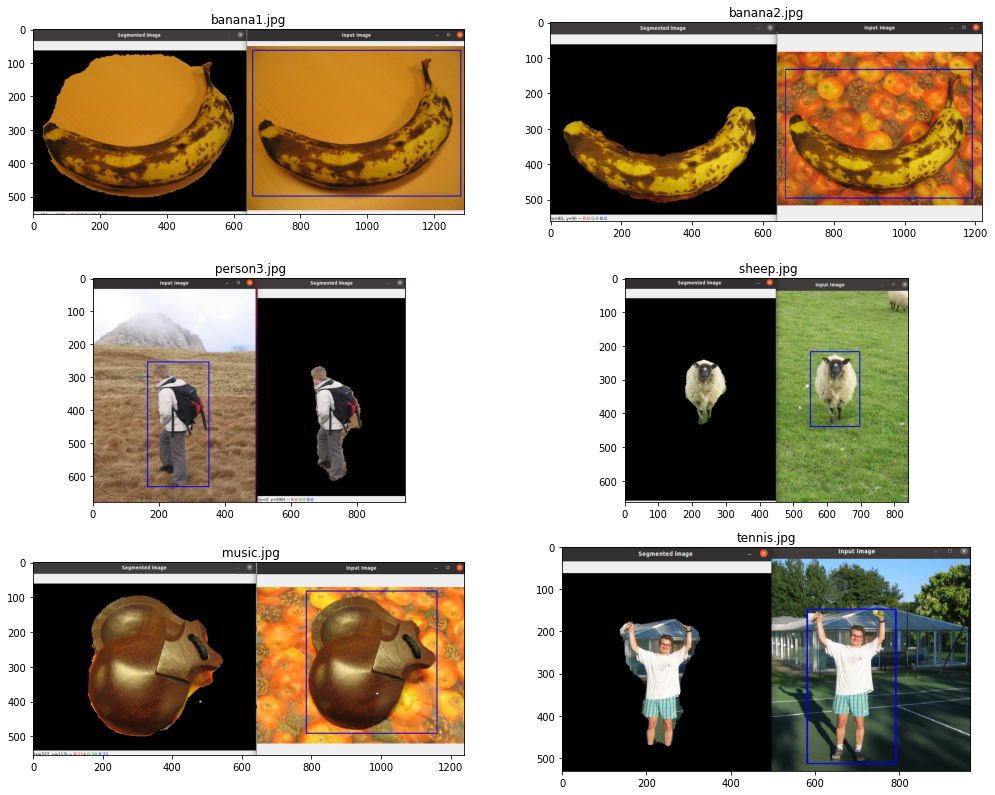

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(17, 14))
ax[0][0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
ax[0][0].title.set_text('banana1.jpg')
ax[0][1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
ax[0][1].title.set_text('banana2.jpg')
ax[1][0].imshow(cv2.cvtColor(im6, cv2.COLOR_BGR2RGB))
ax[1][0].title.set_text(' person3.jpg')
ax[1][1].imshow(cv2.cvtColor(im4, cv2.COLOR_BGR2RGB))
ax[1][1].title.set_text(' sheep.jpg')
ax[2][0].imshow(cv2.cvtColor(im5, cv2.COLOR_BGR2RGB))
ax[2][0].title.set_text(' music.jpg')
ax[2][1].imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
ax[2][1].title.set_text('tennis.jpg')



## Deliverable 2

### The number of iterations of GMM updating and energy minimization.

(-0.5, 283.5, 397.5, -0.5)

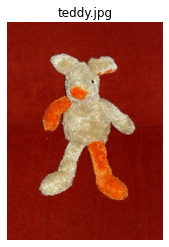

In [ ]:
image=cv2.imread('/content/teddy.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('teddy.jpg')
plt.axis('off')

In [ ]:
im1 = GRABCUT_final(image,  [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=1, k=5)
im3 = GRABCUT_final(image,  [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=3, k=5)
im5 = GRABCUT_final(image,  [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=5, k=5)
im10 = GRABCUT_final(image,  [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=10, k=5)
# im6 = GRABCUT_final(image,  [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=6, k=5)

Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 6...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 7...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 8...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 9...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 10...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Grabcut Ended...

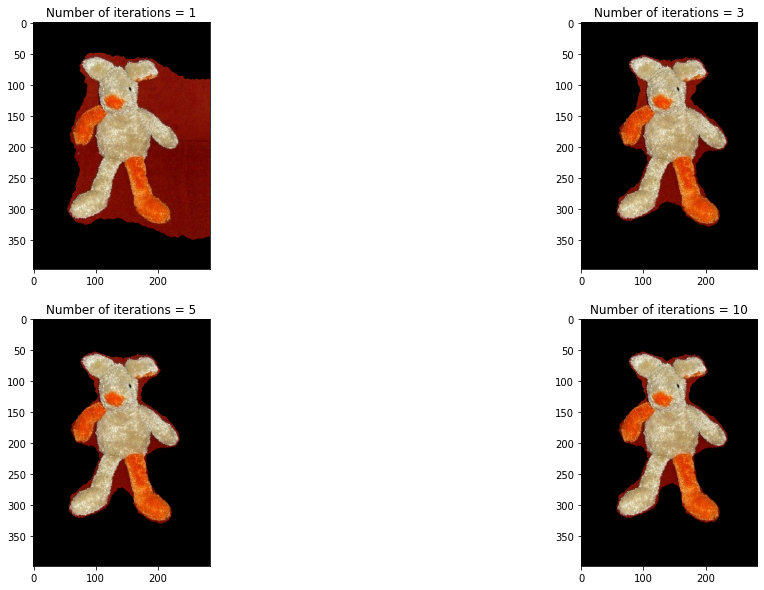

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0][0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
ax[0][0].title.set_text('Number of iterations = 1')
ax[0][1].imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
ax[0][1].title.set_text('Number of iterations = 3')
ax[1][0].imshow(cv2.cvtColor(im5, cv2.COLOR_BGR2RGB))
ax[1][0].title.set_text('Number of iterations = 5')
ax[1][1].imshow(cv2.cvtColor(im10, cv2.COLOR_BGR2RGB))
ax[1][1].title.set_text('Number of iterations = 10')


We notice that when we increase the number of iterations from one to ten , the segmentation tends to converge towards an optimal segmentation.

### 2) The number of mixture components in your GMM.

(-0.5, 283.5, 397.5, -0.5)

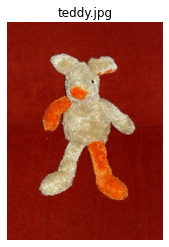

In [ ]:
image=cv2.imread('/content/teddy.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('teddy.jpg')
plt.axis('off')

In [ ]:
im_k1 = GRABCUT_final(image, [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=5, k=1)
im_k5 = GRABCUT_final(image, [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=5,  k=5)
im_k8 = GRABCUT_final(image, [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=5,  k=8)
im_k10 = GRABCUT_final(image, [50, 40, 250, 330], np.ones(image.shape[:2]), 50, iters=5,  k=10)


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Grabcut Ended...

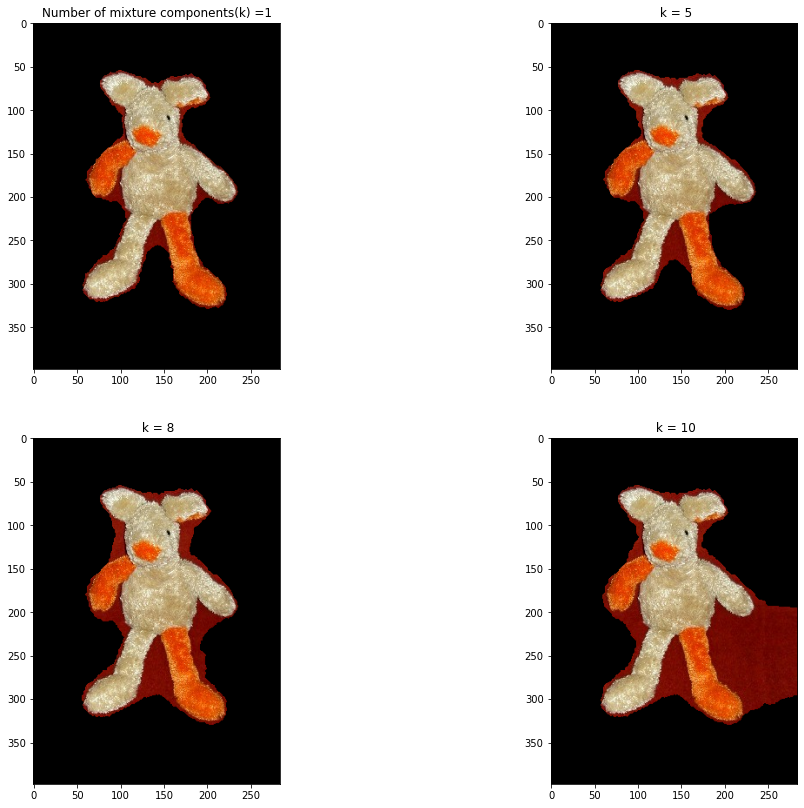

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 14))
ax[0][0].imshow(cv2.cvtColor(im_k1, cv2.COLOR_BGR2RGB))
ax[0][0].title.set_text('Number of mixture components(k) =1')
ax[0][1].imshow(cv2.cvtColor(im_k5, cv2.COLOR_BGR2RGB))
ax[0][1].title.set_text(' k = 5')
ax[1][0].imshow(cv2.cvtColor(im_k8, cv2.COLOR_BGR2RGB))
ax[1][0].title.set_text(' k = 8')
ax[1][1].imshow(cv2.cvtColor(im_k10, cv2.COLOR_BGR2RGB))
ax[1][1].title.set_text(' k = 10')

We can see that we get a reasonable segmentation when the number of mixture components in GMM is set to 5. On increasing the value of k from there we see that the segmentation worsens.

### 3) The choice of gamma.

(-0.5, 512.5, 370.5, -0.5)

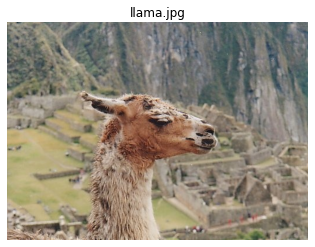

In [ ]:
image=cv2.imread('/content/llama.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('llama.jpg')
plt.axis('off')

In [ ]:
im20  = GRABCUT_final(image, [100, 100, 250, 300], np.ones(image.shape[:2]), 20, iters=5, k=5)
im50  = GRABCUT_final(image, [100, 100, 250, 300], np.ones(image.shape[:2]), 50, iters=5, k=5)
im100 = GRABCUT_final(image, [100, 100, 250, 300], np.ones(image.shape[:2]), 100, iters=5, k=5)


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 1...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 3...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 4...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Iteration 5...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Grabcut Ended...

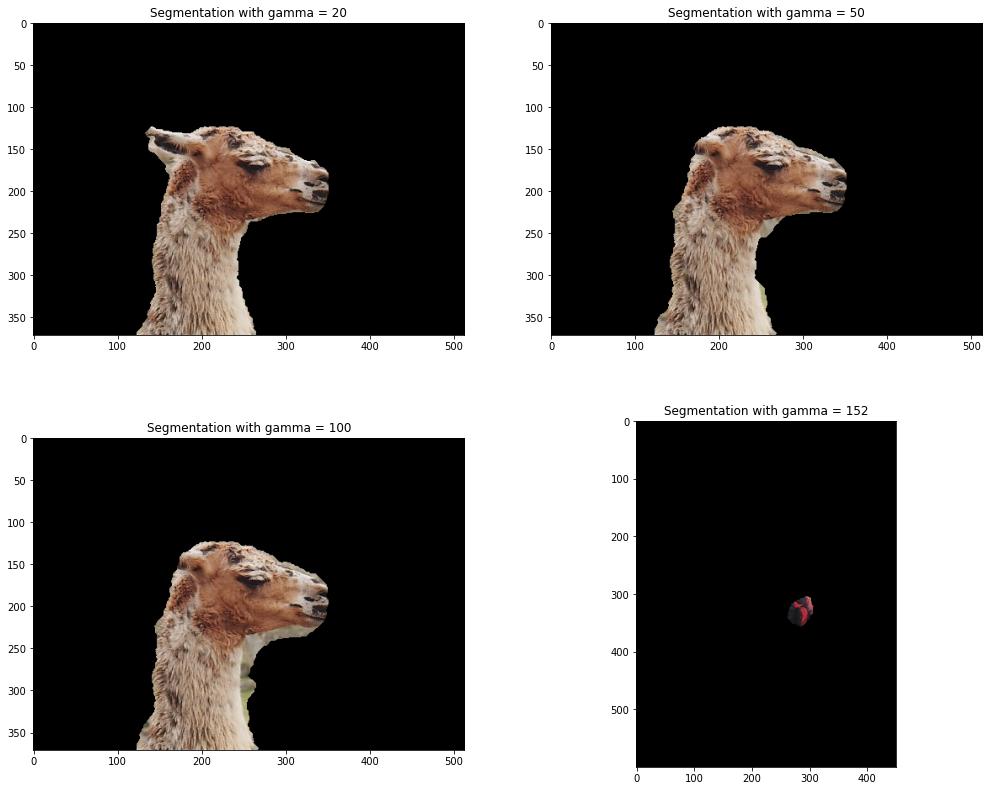

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 14))
ax[0][0].imshow(cv2.cvtColor(im20, cv2.COLOR_BGR2RGB))
ax[0][0].title.set_text('Segmentation with gamma = 20')
ax[0][1].imshow(cv2.cvtColor(im50, cv2.COLOR_BGR2RGB))
ax[0][1].title.set_text('Segmentation with gamma = 50')
ax[1][0].imshow(cv2.cvtColor(im100, cv2.COLOR_BGR2RGB))
ax[1][0].title.set_text('Segmentation with gamma = 100')
ax[1][1].imshow(cv2.cvtColor(im152, cv2.COLOR_BGR2RGB))
ax[1][1].title.set_text('Segmentation with gamma = 152')

As gamma is increased, the segmentation becomes bad. At some value of gamme, there are 0 samples in FG after min cut. We can see this trend visually too. The image disappears into a hole.

### 4) Effect of a tight initial bounding box or a loose bounding box.

(-0.5, 449.5, 599.5, -0.5)

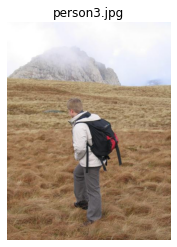

In [ ]:
image=cv2.imread('/content/person3.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('person3.jpg')
plt.axis('off')

In [ ]:

if __name__ == '__main__':
    image = '/content/person3.jpg'               
    run(image)
    cv2.destroyAllWindows()

After choosing the tight and loose bounding box, the results are as follows:

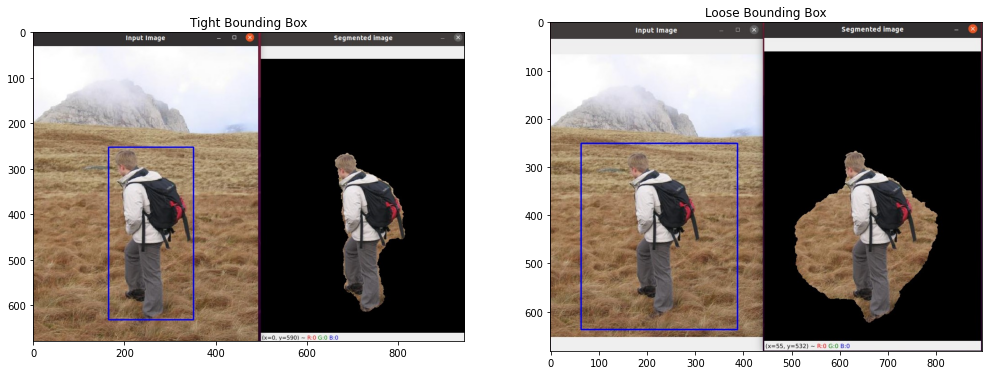

In [ ]:
tight=cv2.imread("/content/tight_box.jpg")
loose=cv2.imread("/content/loose_box.jpg")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 14))
ax[0].imshow(cv2.cvtColor(tight, cv2.COLOR_BGR2RGB))
ax[0].title.set_text('Tight Bounding Box')
ax[1].imshow(cv2.cvtColor(loose, cv2.COLOR_BGR2RGB))
ax[1].title.set_text('Loose Bounding Box')

There should be a tight bounding box .Le us consider the region outside the bounding box to be background. We use these background pixels to fit the GMM responsible for the background. If we don't draw the bounding box tightly, we will lose this information to train the background GMM and  our segmentation will not be accurate.

### 5) Different ways to represent probabilities other than GMMs. 4-neighborhood or 8-neighborhood in your pairwise term.

The different ways to represent probabilities other than GMMs are: \\
*  Histograms
*  Different mixture model


As the number of neighbours increases, the accuracy increases but the algorithm becomes computationally expensive.

